In [9]:
########################################################################
# File            : $Id: $
# Version         : $Revision: 001 $
# Modified On     : $Date: 18th Jan 2022$
# Service version : 1.1.9
# Language        : Python/Jupyter

## Unsupervised Anomaly Detection in Time Series Data

Many applications require being able to decide whether a new observation belongs to the same distribution as existing observations (it is an inlier), or should be considered as different (it is an outlier). Often, this ability is used to monitor the Assets.


The workflow of this notebook is as follows: <br>

1. [Provide Credential.](#packageLoad)
2. [Load Dataset.](#dataLoad)
3. [Compose Anomaly Service and Submit Job.](#pipelineCreation)
4. [Monitor Job](#thresholdstats)
5. [Result Analysis](#groundtruth)

### Credentials

This notebook requires two credentials. Please obtain your own credentials when customizing this notebook for your own work. Please visit __[Anomaly Detection @ IBM](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/Introduction)__ for trial subscription.

In [10]:
# Credentials required for running notebook

Client_ID = "replace-with-valid-client-ID"
Client_Secret = "replace-with-valid-client-Secret"


### Load Dataset<a id="dataLoad"></a>

In the data below, we have single sensor field representing values from one component. The actual meaning of the values isn't that important for the purpose of this example.

The task of anomaly detection is to predict either '1' or '-1' values along with anomaly score. Anomaly label '1' signifies that these samples at that time points are normals. Anomaly label '-1' means these samples are outliers or anomalous. Anomaly models are used to generate alarm in real time.

In [11]:
# try reading datasets from local files
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

datafile_name = "processed_bitcoin.csv"
datafile_path = "./datasets/univariate/" + datafile_name
data_df = pd.read_csv(datafile_path)
print(data_df.describe())
data_df.head(10)

       Weighted_Price
count    30066.000000
mean     11346.641482
std      10260.387826
min       3140.935216
25%       6605.938597
50%       8668.800251
75%      10817.178264
max      61363.600604


,Timestamp,Weighted_Price
0,2017-10-25 07:00:00,5566.168248
1,2017-10-25 08:00:00,5609.117907
2,2017-10-25 09:00:00,5618.544111
3,2017-10-25 10:00:00,5585.530009
4,2017-10-25 11:00:00,5516.217082
5,2017-10-25 12:00:00,5484.641891
6,2017-10-25 13:00:00,5522.335430
7,2017-10-25 14:00:00,5517.409590
8,2017-10-25 15:00:00,5466.962502
9,2017-10-25 16:00:00,5520.523230


Below plot shows the sensor data for each of the variables, the user can also choose/resample data based upon the domain knowledge.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc339d84150>],
      dtype=object)

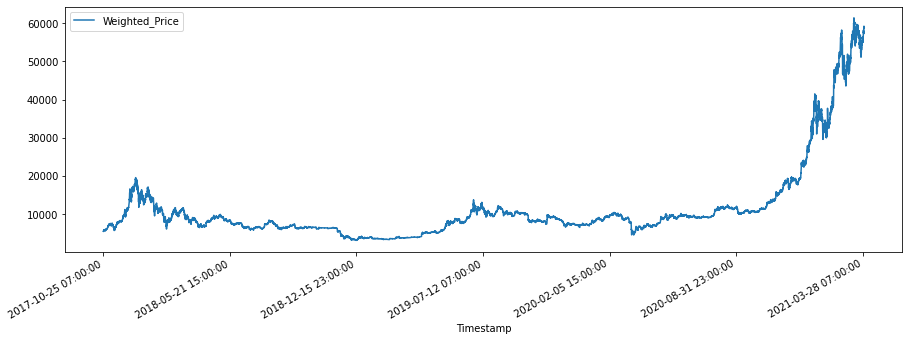

In [12]:
timestamp = "Timestamp"
value = "Weighted_Price"
data_df.plot(x=timestamp, y=value, subplots=True, figsize=(15, 5))

### Anomaly Service Creation and Job Submission <a id="pipelineCreation"></a>

Now, we compose anomaly service. User need to provide a local file name and some meta-data information about the data (target_column, time_column, time_format, etc). The detail of these parameters are available at __[IBM API Hub @ IBM](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/api/API--ai4industry--anomaly-detection-api#batch_uni)__ for Univariate Anomaly detection service.

In [13]:
import requests
import time
import json


job_ids = {}

files = {'data_file': (datafile_name, open(datafile_path, 'rb'))}

headers = {
    'X-IBM-Client-Id': Client_ID,
    'X-IBM-Client-Secret': Client_Secret,
    'accept': "application/json",
    }

data = {
    'target_column': value,
    'time_column': timestamp,
    'time_format': '%Y-%m-%d %H:%M:%S',
    'prediction_type': 'entire',
    'algorithm_type': 'DeepAD',
    'lookback_window': 100,
    'observation_window': 100,
    'labeling_method': 'Contextual-Anomaly',
    'labeling_threshold': 10,
    'anomaly_estimator': 'Default',
}

post_response = requests.post("https://api.ibm.com/ai4industry/run/anomaly-detection/timeseries/univariate/batch", 
                              data=data,
                              files=files,
                              headers=headers)

post_r_json = post_response.json()
anomaly_service_jobId = None
if 'jobId' in post_r_json:
    anomaly_service_jobId = post_r_json['jobId']
    print ('submitted successfully job : ', post_r_json['jobId'])
else:
    print (post_r_json)

submitted successfully job :  52ad398b-d783-472f-9d7a-b1e7368ad1dc


### Monitor Anomaly Job <a id="pipelineCreation"></a>

Each anomaly detection service call generates one job id. We now track the progress of job. Detail of job execution is covered at __[Get Result](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/api/API--ai4industry--anomaly-detection-api#get_result_by_id)__. You may need to the following cell at periodic interval.

In [21]:
import http.client
import json


conn = http.client.HTTPSConnection("api.ibm.com")

headers = {
    'X-IBM-Client-Id': Client_ID,
    'X-IBM-Client-Secret': Client_Secret,
    'accept': "application/json"
    }

conn.request("GET", "/ai4industry/run/result/"+anomaly_service_jobId, headers=headers)
res = conn.getresponse()
data = res.read().decode("utf-8")
json_data = json.loads(data)


### Anomaly Results <a id="groundtruth"></a>

Now we plot the anomaly score and anomaly label detected by the service.

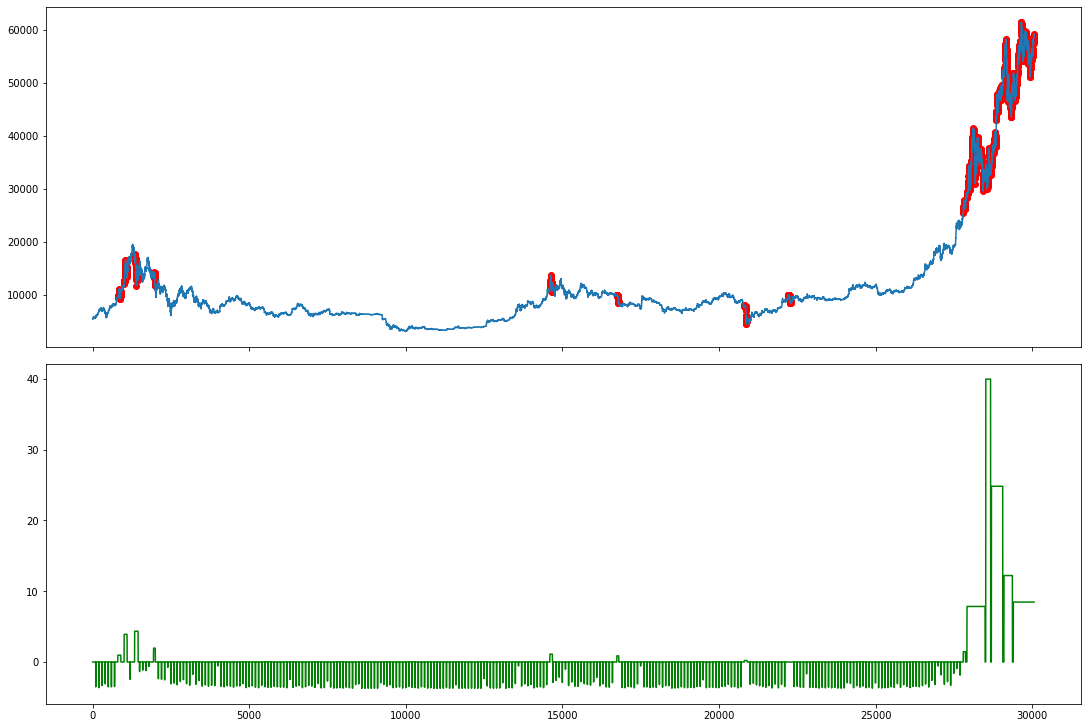

In [22]:
result = json_data['summary']['result']
anomaly_scores = []
anomaly_labels = []
for item in result:
    anomaly_scores.append(item['value']['anomaly_score'][0])
    anomaly_labels.append(item['value']['anomaly_label'][0])
plot_data_df = data_df.copy()
plot_data_df['anomaly_label'] = anomaly_labels
plot_data_df['anomaly_score'] = anomaly_scores
label_df = plot_data_df.loc[plot_data_df['anomaly_label'] == -1.0, (timestamp, value)]
fig, ax = plt.subplots(2,sharex=True,constrained_layout=True, figsize=(15,10))
# the x axis is indices because it takes forever to plot results with timestamp as x axis
ax[0].plot(plot_data_df.index, plot_data_df[value])
ax[0].scatter(label_df.index,label_df[value], color='red')
ax[1].plot(plot_data_df.index, plot_data_df['anomaly_score'], color='green')
plt.show()